In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import hydrosensordesign as hsd
import matplotlib.pyplot as plt

In [2]:
# Load Data
df_cleaned = pd.read_pickle("outputs/df_cleaned.pkl")
gauges_gdf = gpd.read_file("outputs/gauges.gpkg")
flowlines_gdf = gpd.read_file("outputs/flowlines.gpkg")
usgs_index_df = pd.read_pickle("outputs/usgs_index.pkl")
huc6 = gpd.read_file("outputs/huc6_shapefile/huc6_tx_gulf.shp").to_crs(4269)

In [3]:
X = df_cleaned.values.astype(float)
comid = np.asarray(df_cleaned.columns)
n_time, n_sites = X.shape
print('X shape:', X.shape)

train_frac = 0.7
split_idx = int(train_frac * n_time)
X_train = X[:split_idx]
X_test = X[split_idx:]
print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

X shape: (4017, 64907)
Train shape: (2811, 64907)
Test shape : (1206, 64907)


In [4]:
def get_flowlines_centroids(flowlines_gdf, id_field, id_list):
    flowlines_copy = flowlines_gdf.copy()
    # convert to string
    flowlines_copy[id_field] = flowlines_copy[id_field].astype(str)
    # convert to string
    id_list = pd.Index(id_list.astype(str))
    # dictionary for id and and idx
    id_to_idx = {cid: j for j, cid in enumerate(id_list)}

    # filter flowlines in id_list
    flowlines_filtered = flowlines_copy.loc[flowlines_copy[id_field].isin(comid)].copy()
    # map idx to id_field
    flowlines_filtered['idx'] = flowlines_filtered[id_field].astype(str).map(id_to_idx).astype(int)

    # reproject to wgs84 (common projected CRS)
    flowlines_wgs = flowlines_filtered.to_crs(epsg=5070)
    # compute centroids
    centroids = flowlines_wgs.geometry.centroid
    # convert centroids back to geographic CRS
    centroids_ll = gpd.GeoSeries(centroids, crs='EPSG:5070').to_crs(flowlines_gdf.crs)

    # extract lat, lon
    flow_lat = centroids_ll.y.values
    flow_lon = centroids_ll.x.values

    flow_centroid_gdf = gpd.GeoDataFrame(
        {
            id_field: flowlines_filtered[id_field].astype(int),
            "idx": flowlines_filtered['idx'],
            "lat": flow_lat,
            "lon": flow_lon,
        },
        geometry=gpd.points_from_xy(flow_lon, flow_lat),
        crs=flowlines_gdf.crs
    )
    return flow_centroid_gdf    

In [5]:
# Make a copy to avoid modifying the original
flowlines_copy = flowlines_gdf.copy()
flowlines_copy["COMID"] = flowlines_copy["COMID"].astype(str)

col_ids = pd.Index(df_cleaned.columns.astype(str))
# dictionary for comid and idx
comid_to_col = {cid: j for j, cid in enumerate(col_ids)}

# Filter flowlines to only COMIDs in df_cleaned
flowlines_filtered = flowlines_copy.loc[flowlines_copy["COMID"].isin(comid)].copy()
# map idx to comid
flowlines_filtered["idx"] = flowlines_filtered["COMID"].astype(str).map(comid_to_col).astype(int)

# Reproject to a projected CRS (x,y)
gdf_proj = flowlines_filtered.to_crs(epsg=5070)

# Compute centroids
centroids = gdf_proj.geometry.centroid

# Convert centroids back to geographic CRS (lat/lon)
centroids_ll = gpd.GeoSeries(centroids, crs=gdf_proj.crs).to_crs(epsg=4269)

# Extract lat / lon 
flow_lat = centroids_ll.y.values
flow_lon = centroids_ll.x.values

# Create "(lat, lon)" formatted strings
latlon_str = [f"({lat}, {lon})" for lat, lon in zip(flow_lat, flow_lon)]

# Build final DataFrame (same order as flowlines_gdf)
flow_lat_lon = flowlines_filtered.assign(
    lat=flow_lat,
    lon=flow_lon,
    lat_lon=latlon_str
)[["COMID", "lat_lon","idx"]]
# need to save crs for lat lon coord_crs = 
flow_lat_lon[:5]

,COMID,lat_lon,idx
0,5256723,"(32.61868276306611, -95.50137088386384)",26936
1,5256353,"(32.63013428977702, -95.51512370866801)",26782
2,5256289,"(32.64981553314542, -95.53823507416166)",26750
3,5256227,"(32.661436989062686, -95.5524962744192)",26720
4,5256215,"(32.668785323658845, -95.54849766843817)",26714


In [6]:
flow_centroid_gdf = get_flowlines_centroids(flowlines_gdf, 'COMID', comid)
flow_centroid_gdf[:5]

,COMID,idx,lat,lon,geometry
0,5256723,26936,32.618683,-95.501371,POINT (-95.50137 32.61868)
1,5256353,26782,32.630134,-95.515124,POINT (-95.51512 32.63013)
2,5256289,26750,32.649816,-95.538235,POINT (-95.53824 32.64982)
3,5256227,26720,32.661437,-95.552496,POINT (-95.5525 32.66144)
4,5256215,26714,32.668785,-95.548498,POINT (-95.5485 32.66879)


In [7]:
usgs_index_df_valid = usgs_index_df.loc[usgs_index_df['COMID'].isin(comid.astype(int))]
usgs_index_filter = usgs_index_df_valid[np.abs(usgs_index_df_valid['COMID'])!=9999]
usgs_index_lon = usgs_index_filter['Long_snap'].values
usgs_index_lat = usgs_index_filter['Lat_snap'].values
usgs_index_coord = [f"({lat}, {lon})" for lat, lon in zip(usgs_index_lat, usgs_index_lon)]


usgs_points_gdf = gpd.GeoDataFrame(
    {
        "COMID": usgs_index_filter['COMID'],
        "coord": usgs_index_coord,
        "lat": usgs_index_lat,
        "lon": usgs_index_lon,
    },
    geometry=gpd.points_from_xy(usgs_index_lon, usgs_index_lat),
    crs='EPSG:4269'
)
usgs_points_gdf

,COMID,coord,lat,lon,geometry
0,3585554,"(30.1005540472, -99.2830259334)",30.100554,-99.283026,POINT (-99.28303 30.10055)
1,1438379,"(29.933918594, -95.2338897638)",29.933919,-95.233890,POINT (-95.23389 29.93392)
2,3168874,"(28.0593639757, -98.0967707015)",28.059364,-98.096771,POINT (-98.09677 28.05936)
3,1440525,"(29.7488063747, -95.29054195760001)",29.748806,-95.290542,POINT (-95.29054 29.74881)
4,1520249,"(30.2595874939, -95.3025198277)",30.259587,-95.302520,POINT (-95.30252 30.25959)
...,...,...,...,...,...
471,1279694,"(32.9659536513, -96.9445361442)",32.965954,-96.944536,POINT (-96.94454 32.96595)
472,1293010,"(32.9600600806, -96.6144209866)",32.960060,-96.614421,POINT (-96.61442 32.96006)
473,1306815,"(32.9456882556, -97.583105668)",32.945688,-97.583106,POINT (-97.58311 32.94569)
475,5254557,"(32.8978980877, -96.2533123486)",32.897898,-96.253312,POINT (-96.25331 32.8979)


In [8]:
existing_sensors = usgs_points_gdf.merge(
                                        flow_centroid_gdf[['COMID', "idx"]],
                                        on='COMID',
                                        how="left"
                                        )
existing_sensors = flow_centroid_gdf[flow_centroid_gdf['COMID'].isin(existing_sensors['COMID'])]
print(existing_sensors.shape)
existing_sensors[:5]

(447, 5)


,COMID,idx,lat,lon,geometry
46,5256789,26943,32.806660,-95.914652,POINT (-95.91465 32.80666)
60,5253949,26358,33.129494,-96.069243,POINT (-96.06924 33.12949)
95,5254557,26440,32.893765,-96.240240,POINT (-96.24024 32.89376)
491,5255921,26567,32.772459,-95.790877,POINT (-95.79088 32.77246)
837,5278868,27896,32.331875,-94.354671,POINT (-94.35467 32.33188)


In [9]:
selected_global = pd.read_pickle("outputs/global_sensors.pkl")

In [10]:
selected_basin = hsd.select_sensors(X_train=X_train,
                                    boundaries=huc6, basin_field='HUC_6',
                                    flowlines=flow_centroid_gdf, flow_id_field='COMID',
                                    existing_sensors=existing_sensors,
                                    expansion=False)


Selected 447 optimal sensor locations


In [11]:
flow_lat_lon["COMID"] = flow_lat_lon["COMID"].astype(int)
df_usgs = flow_lat_lon[flow_lat_lon["COMID"].isin(usgs_index_df['COMID'])].copy()

lat_usgs, lon_usgs = hsd.utils.extract_coordinates(df_usgs['lat_lon'])

In [12]:
global_comids_idx = np.array(selected_global, dtype=int)
global_comids = pd.DataFrame(comid[global_comids_idx],columns=['COMID'])
df_global = flow_lat_lon[flow_lat_lon["COMID"].isin(global_comids['COMID'].astype(int))].copy()

lat_global, lon_global = hsd.utils.extract_coordinates(df_global['lat_lon'])

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# use coords_to_points from utils
def latlon_to_gdf(lat, lon, crs="EPSG:4326"):
    return gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(lon, lat),
        crs=crs
    )

def plot_s10_latlon(
    lat_usgs, lon_usgs,
    lat_huc6, lon_huc6,
    lat_global, lon_global,
    huc6_boundaries=None,
    extent=None,
    figsize=(12, 6),
    dpi=300,
    save_path=None,
):
    # --- convert to GeoDataFrames internally
    usgs = latlon_to_gdf(lat_usgs, lon_usgs)
    huc6 = latlon_to_gdf(lat_huc6, lon_huc6)
    glob = latlon_to_gdf(lat_global, lon_global)

    if huc6_boundaries is not None:
        huc6_polys = huc6_boundaries.to_crs("EPSG:4326")
    else:
        huc6_polys = None

    # --- auto extent
    if extent is None:
        all_lon = np.concatenate([lon_usgs, lon_huc6, lon_global])
        all_lat = np.concatenate([lat_usgs, lat_huc6, lat_global])
        extent = [
            all_lon.min() - 0.5, all_lon.max() + 0.5,
            all_lat.min() - 0.5, all_lat.max() + 0.5,
        ]

    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(
        1, 2,
        figsize=figsize,
        dpi=dpi,
        subplot_kw={"projection": proj},
        constrained_layout=True,
    )

    def base(ax):
        ax.set_extent(extent, crs=proj)
        ax.add_feature(cfeature.LAND, alpha=0.15)
        ax.add_feature(cfeature.OCEAN, alpha=0.10)
        ax.add_feature(cfeature.STATES, linewidth=0.4)
        ax.add_feature(cfeature.BORDERS, linewidth=0.01, linestyle='dotted')
        if huc6_polys is not None:
            ax.add_geometries(
                huc6_polys.geometry,
                crs=proj,
                facecolor="none",
                edgecolor="black",
                linewidth=0.4,
            )

    # -------- LEFT PANEL
    ax = axs[0]
    base(ax)
    ax.set_title("USGS gauges vs HUC6 reconfigured")

    ax.scatter(
        huc6.geometry.x, huc6.geometry.y, c='tab:orange',
        s=14, alpha=1, transform=proj,
        label="HUC6 reconfigured"
    )
    ax.scatter(
        usgs.geometry.x, usgs.geometry.y, c='k',
        s=12, alpha=0.6, transform=proj,
        label="USGS gauges"
    )
    ax.legend(frameon=False)

    # -------- RIGHT PANEL
    ax = axs[1]
    base(ax)
    ax.set_title("Global QR vs HUC6 reconfigured")

    ax.scatter(
        huc6.geometry.x, huc6.geometry.y, c='tab:orange',
        s=12, alpha=1, transform=proj,
        label="HUC6 reconfigured"
    )
    ax.scatter(
        glob.geometry.x, glob.geometry.y, c='g',
        s=14, alpha=0.3, transform=proj,
        label="Global QR reconfigured"
    )
    ax.legend(frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")

    return fig, axs


In [14]:
selected_basin

,HUC_6,COMID,idx,lat,lon
0,120100,8333624,53336,29.991496,-93.786683
1,120100,9533777,54568,31.900347,-93.926002
2,120100,8328658,51962,31.173721,-93.566137
3,120100,8330858,52786,30.550839,-93.730720
4,120100,5279658,28238,32.427175,-94.691504
...,...,...,...,...,...
442,121102,3172512,22444,27.851864,-97.534227
443,121102,1583941,16579,27.848305,-97.891748
444,121102,1588293,16794,27.402693,-97.475480
445,121102,1584643,16633,27.559261,-97.571775


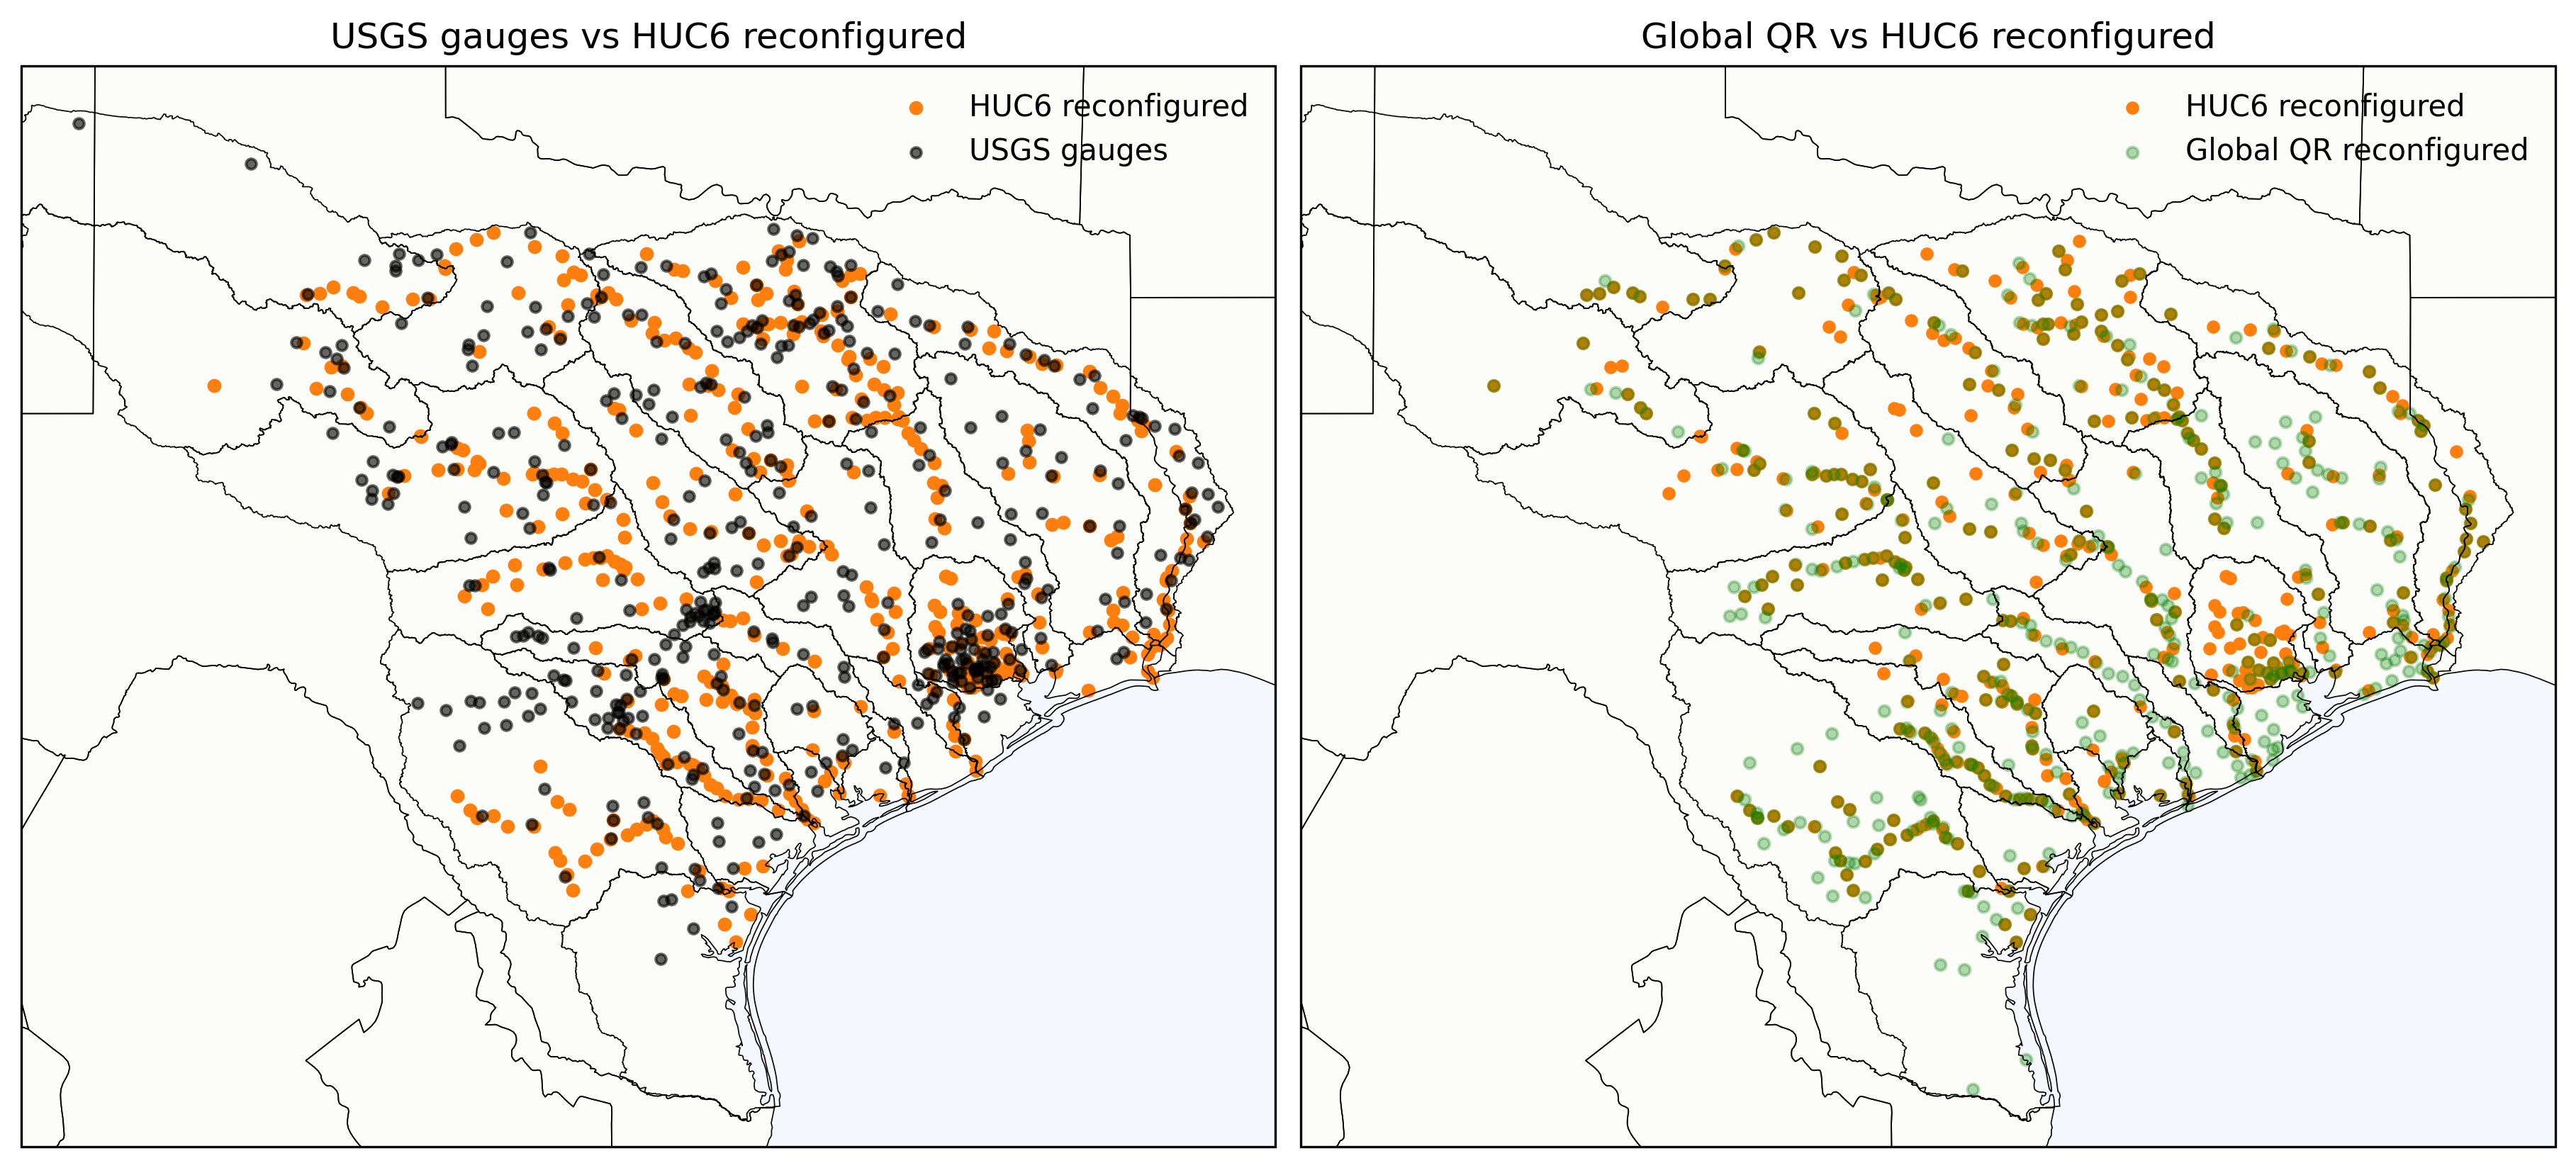

In [15]:
lat_huc6 = selected_basin['lat']
lon_huc6 = selected_basin['lon']
fig, axs = plot_s10_latlon(
    lat_usgs, lon_usgs,
    lat_huc6, lon_huc6,
    lat_global, lon_global,
    huc6_boundaries = huc6
)

plt.show()